In [15]:
import torch
import numpy as np
from torchvision.io import image as torch_image
import cv2
import pathlib
import torchvision
from scipy.ndimage.measurements import label
from PIL.Image import Image, open as im_open
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont

/tmp/ipykernel_1074553/1699421179.py:7: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [16]:
def remove_noise(mask, kernel_size, iterations=2):
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return opening


In [17]:
def mask_to_bboxes(mask, kernel_size=(8, 8), remove_noise_flag=True):
    if remove_noise_flag:
        mask = remove_noise(mask, kernel_size=kernel_size)

    # Apply threshold to create a binary mask
    binary_mask = mask

    # Label connected components
    labeled_array, num_features = label(binary_mask)

    bboxes = []
    for i in range(1, num_features + 1):
        # Get the individual component mask
        component_mask = (labeled_array == i)

        # Find the coordinates of the bounding box
        y_coords, x_coords = np.where(component_mask)
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes


In [18]:
pred_dir = pathlib.Path("/home/fummicc1/codes/signate/") / "test" / "modern" / "predicted"

In [19]:
CLASS_MAP = {  
  0: "0_background",
  1: "2_handwritten",
  2: "3_typography",
  3: "4_illustration",
  4: "5_stamp",
  5: "6_headline",
  6: "7_caption",
  7: "8_textline",
}

In [20]:
all_label_color_map = {
    "0_background": "white",
    "1_overall": "red",
    "2_handwritten": "blue",
    "3_typography": "green",
    "4_illustration": "yellow",
    "5_stamp": "orange",
    "6_headline": "pink",
    "7_caption": "purple",
    "8_textline": "gray",
}

/tmp/ipykernel_1074553/3409928191.py:46: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_w, text_h = fnt.getsize(key)


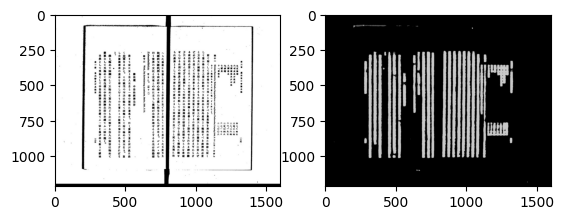

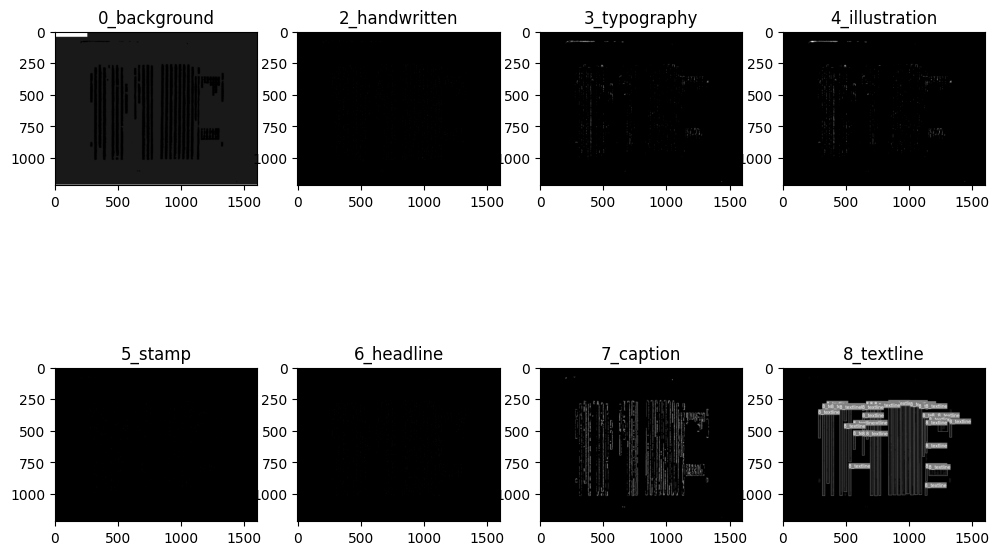

In [21]:
import math
import matplotlib.pyplot as plt
import random

pred_dirs = list(pred_dir.iterdir())
random.shuffle(pred_dirs)
for pred_path in pred_dirs:
    # print(pred_path.as_posix())
    core_fig, core_ax = plt.subplots(1, 2)
    original_path = pred_path.parent.parent / "images" / pred_path.name    
    pred = cv2.imread(pred_path.as_posix(), 1).astype(np.uint8)
    original = cv2.imread(original_path.as_posix()).astype(np.uint8)
    pred = pred[:, :, 0]
    core_ax[0].imshow(original)
    core_ax[1].imshow(pred, cmap="gray")    
    pred = np.array(pred)
    pred //= 25
    
    fig, ax = plt.subplots(ncols=4, nrows=math.ceil(len(CLASS_MAP) / 4))
    fig.set_size_inches(12, 8)
    
    out_path = pred_path.parent.parent / "bbox"
    out_path.mkdir(exist_ok=True)
    out_path = out_path / f"{pred_path.stem}.txt"
    # print(out_path.as_posix())
    with out_path.open(mode="w") as f:
        
        for index, key in CLASS_MAP.items():        
            img = (pred == index)
            sub = ax[index // 4][index % 4]
            img = img.astype(np.uint8)
            pred_pil = img * 25        
            
            # Convert the segmentation mask to bounding boxes
            bboxes = mask_to_bboxes(img, remove_noise_flag=False)
            
            pred_pil = PIL.Image.fromarray(pred_pil)
            
            draw = PIL.ImageDraw.Draw(pred_pil)
            for box in bboxes:
                area = (box[3] - box[1]) * (box[2] - box[0])
                # print("box are", area)
                if area <= 800:
                    continue
                fnt = PIL.ImageFont.truetype("/home/fummicc1/codes/signate/arial.ttf", size=40)
                text_w, text_h = fnt.getsize(key)
                # print("category", category, "box", box)
                draw.rectangle(box, outline=all_label_color_map[key], width=3)
                draw.rectangle([box[0], box[1], box[0] + text_w, box[1] + text_h], fill=all_label_color_map[key])
                draw.text([box[0], box[1]], key, font=fnt, fill="white") 
                imgwidth = img.shape[1]
                imgheight = img.shape[0]
                f.write(f"{key[0]} {box[0] / imgwidth} {box[1] / imgheight} {box[2] / imgwidth} {box[3] / imgheight}")
                f.write("\n")
            
            sub.imshow(pred_pil, cmap="gray")
            sub.set_title(key)

            # print("label", key, "Bounding boxes:", bboxes)
        break
    # fig.tight_layout()